In [1]:
%matplotlib inline

# First version authored by Aaron McDaid  - aaron.mcdaid@gmail.com. But feel free to add to it.
# I'm quite new to some of these modules ('pandas' in particular, so don't hesitate to send feedback!)

import matplotlib.pyplot as plt # for the scatter plots

import pandas # to read the data from the csv file
import itertools as it # to help deal with generators
from collections import defaultdict
import math

from scipy.stats.stats import pearsonr # to compute correlation. Remember variance-explained is correlation-squared

# Next two imports for the regression
import statsmodels.formula.api as smf

In [2]:
tr1 = pandas.read_csv('train_data_with_long_lat_another.csv')

In [3]:
tr1.columns.values # see the column names, make sure we've got what we need

array(['Unnamed: 0', 'Id', 'Title', 'FullDescription', 'LocationRaw',
       'LocationNormalized', 'ContractType', 'ContractTime', 'Company',
       'Category', 'SalaryRaw', 'SalaryNormalized', 'SourceName', 'town',
       'latitude', 'longitude', 'address', 'country', 'London',
       'Manchester', 'Birmingham', 'Leeds', 'Glasgow', 'Liverpool',
       'Southampton', 'Newcastle', 'Nottingham', 'Sheffield'], dtype=object)

In [4]:
# Define a few useful functions

# the first 10 from a generator, returned as a list
def hd(g, n=10):
    return list( it.islice(g, n))

# convert a pandas column to a good old generator
def columnToGen(c):    
    for x in c.values:
        yield x

In [5]:
# In the next few cells, we identify the ten most common words in the 'Title'

title_word_frequency = defaultdict(int)
title_words=it.chain.from_iterable(x.tolist()[0].lower().split() for x in tr1[['Title']].values)
title_words = it.chain(title_words)
for tw in title_words:
    title_word_frequency[tw] = title_word_frequency[tw] + 1

In [6]:
# works that appear a lot, but I think are probably boring
discarded_words = set(['****','/','de','to','****k'])

In [7]:
# Finally print the top ten words

top10 = hd(sorted(list(((v, k) for k, v in title_word_frequency.items() if k not in discarded_words)), reverse=True))
for top in top10:
    print top
top10words = list(v for k,v in top10)
print top10words

(11152, 'developer')
(5438, 'engineer')
(4361, 'analyst')
(4219, 'manager')
(3888, 'senior')
(3728, 'software')
(3309, 'support')
(2537, 'web')
(2402, 'c')
(2261, 'it')
['developer', 'engineer', 'analyst', 'manager', 'senior', 'software', 'support', 'web', 'c', 'it']


In [8]:
# Create 10 binary columns in the data
# i.e. create a 'contains_developer' column, containing 'True' or
# 'False' depending on whether 'developer' appears in the 'Title' field.
# Case insensitive

for top10 in top10words:
    tr1['contains_' + top10] = list(
        (top10.lower() in y.split()) # the boolean test
        for x in tr1[['Title']].values # the individual cells in a the Title pandas column
        for y in [x.tolist()[0].lower()] # (ugly) convert the cells to a plain old string
    )

In [9]:
# print out the column names again, to verify that the ten 'contains_*' columns are now present
tr1.columns.values

array(['Unnamed: 0', 'Id', 'Title', 'FullDescription', 'LocationRaw',
       'LocationNormalized', 'ContractType', 'ContractTime', 'Company',
       'Category', 'SalaryRaw', 'SalaryNormalized', 'SourceName', 'town',
       'latitude', 'longitude', 'address', 'country', 'London',
       'Manchester', 'Birmingham', 'Leeds', 'Glasgow', 'Liverpool',
       'Southampton', 'Newcastle', 'Nottingham', 'Sheffield',
       'contains_developer', 'contains_engineer', 'contains_analyst',
       'contains_manager', 'contains_senior', 'contains_software',
       'contains_support', 'contains_web', 'contains_c', 'contains_it'], dtype=object)

In [10]:
# we'll target the logarithm of the salary, not the salary itself

tr1['SalaryNormalizedLog'] = list( math.log(sn) for sn in columnToGen(tr1['SalaryNormalized']) )

In [11]:
# the fields we'll use in the regression
# - distance from London
# - longitude
# - latitude
# - the ten boolean columns from Title
formula = 'SalaryNormalizedLog ~ London + longitude + latitude + ' + '+'.join('contains_'+top10 for top10 in top10words)
print formula

SalaryNormalizedLog ~ London + longitude + latitude + contains_developer+contains_engineer+contains_analyst+contains_manager+contains_senior+contains_software+contains_support+contains_web+contains_c+contains_it


In [12]:
#  ***************************************
#  ************** IMPORTANT **************
#  ***************************************
# This Jupyter cell - and the following one - are 'cheating', by measuring the performance within the
# same dataset that was used for estimating the parameters. Later, I'll do
# a more appropriate 'train-and-test' division. The good news is that the
# performance doesn't change much.



res = smf.ols(formula, data = tr1).fit()
print res.summary()
print res.params
#res.predict(tr1)

                             OLS Regression Results                            
Dep. Variable:     SalaryNormalizedLog   R-squared:                       0.166
Model:                             OLS   Adj. R-squared:                  0.166
Method:                  Least Squares   F-statistic:                     590.6
Date:                 Tue, 26 Sep 2017   Prob (F-statistic):               0.00
Time:                         16:08:48   Log-Likelihood:                -17907.
No. Observations:                38483   AIC:                         3.584e+04
Df Residuals:                    38469   BIC:                         3.596e+04
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

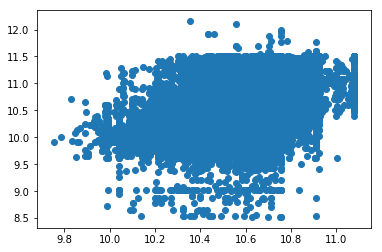

In [13]:
plt.scatter(res.fittedvalues, tr1['SalaryNormalizedLog'])

In [14]:
# Next, we take a more appropriate train and test approach.
# Divide the dataset into ten bins. For each bin, estimate coefficients
# in the remaining 90% of the, then make predictions in the 10% (the 'current' bin)
# and compare the predictions to the truth.

In [17]:
NUMBER_OF_BINS=10

preds = []
truth = []

for bin in range(NUMBER_OF_BINS):
    # divide the data into two, nonoverlapping, portions
    test     = tr1[tr1.index % NUMBER_OF_BINS == bin]
    subtrain = tr1[tr1.index % NUMBER_OF_BINS != bin]
    
    # estimate coefficients
    res = smf.ols(formula, data = subtrain).fit()
    print res.summary()

    # make predictions in the current bin, based on the coefficients
    # that have been estimated in 'subtrain'
    somePreds = res.predict(test)
    
    # store the predictions, and the corresponding truths.
    preds.extend(somePreds.tolist())
    truth.extend( list(columnToGen(test['SalaryNormalizedLog'])))

# verify that the number of predictions is the same as the number of items in the dataset
assert len(preds) == tr1.shape[0]

                             OLS Regression Results                            
Dep. Variable:     SalaryNormalizedLog   R-squared:                       0.167
Model:                             OLS   Adj. R-squared:                  0.167
Method:                  Least Squares   F-statistic:                     534.9
Date:                 Tue, 26 Sep 2017   Prob (F-statistic):               0.00
Time:                         16:09:20   Log-Likelihood:                -16067.
No. Observations:                34634   AIC:                         3.216e+04
Df Residuals:                    34620   BIC:                         3.228e+04
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

                             OLS Regression Results                            
Dep. Variable:     SalaryNormalizedLog   R-squared:                       0.167
Model:                             OLS   Adj. R-squared:                  0.166
Method:                  Least Squares   F-statistic:                     533.1
Date:                 Tue, 26 Sep 2017   Prob (F-statistic):               0.00
Time:                         16:09:21   Log-Likelihood:                -16119.
No. Observations:                34635   AIC:                         3.227e+04
Df Residuals:                    34621   BIC:                         3.238e+04
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

                             OLS Regression Results                            
Dep. Variable:     SalaryNormalizedLog   R-squared:                       0.167
Model:                             OLS   Adj. R-squared:                  0.166
Method:                  Least Squares   F-statistic:                     532.7
Date:                 Tue, 26 Sep 2017   Prob (F-statistic):               0.00
Time:                         16:09:21   Log-Likelihood:                -16091.
No. Observations:                34635   AIC:                         3.221e+04
Df Residuals:                    34621   BIC:                         3.233e+04
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

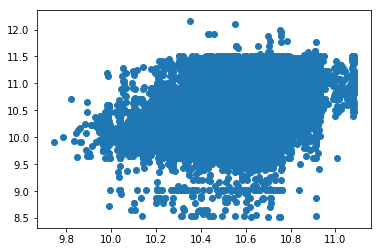

In [18]:
plt.scatter(preds, truth)

In [19]:
# Compute the variance-explained, which is the square of the correlation
# It's between zero and one. We want this to be as big as possible, and it
# is currently 0.165

cr = pearsonr(preds, truth)
print cr[0] ** 2

0.165876290707
